### Pobieranie bazy danych MNIST

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape #70 000 obrazów opisanych 784 cechami

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

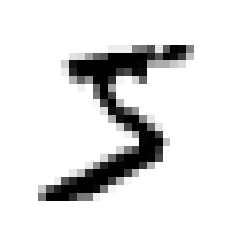

In [7]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8) # zmiana wartości String -> uint8

In [10]:
X_train, X_test, y_train, y_test = X[:60_000],X[60_000:], y[:60_000], y[60_000:] 

# Klasyfikator binarny
W tym przypadku zdolny do rozpoznania piątek i niepiątek

In [11]:
y_train_5 =(y_train==5)
y_test_5 =(y_test==5)

<b>Klasyfikator stochatystycznego spadku wzdłuż gradientu - Stochastic Gradient Descent SGD </b></br>
Wydajny dla dużych zestawów danych. Przykłady przetwarzane niezależnie od siebie. Dobry dla uczenia przyrostowego.

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3,random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# Miara wydajności

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Dokładność jako miara wydajności

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
print(n_correct / len(y_pred)) # Wyświetla wyniki 0.9502, 0.96565 i 0.96495

0.96785


In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Macierz pomyłek

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

In [18]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]], dtype=int64)

Kolejno w macierzy: prawdziwie negatywne, fałszywie pozytywne, fałszywie negatywne, fałszywie pozytywne

In [20]:
y_train_perfect_predictions = y_train_5

In [21]:
confusion_matrix(y_train_5, y_train_perfect_predictions) # tak wygląda macierz przy doskonałym klasyfikowaniu

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [22]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522), precyzja - rozpoznając 5 nie myli się jedynie w 75% przypadków

0.7547327860613168

In [23]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325), dokładność - prawidłowo rozpoznaje 83% wszystkich piątek

0.8310274857037447

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.791044776119403

In [25]:
y_scores = sgd_clf.decision_function([some_digit]) # zwraca obliczony wynik dla każdej próbki

In [26]:
y_scores 

array([2164.22030239])

In [27]:
threshold = 0 # domyślna wartość klasyfikatora SGD to 0, zmieniając ją zmieniamy próg kompromisu między precyzją a pełnością
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # wyniki decyzyjne dla wszystkich przykładów

In [52]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja")
    plt.plot(thresholds, recalls[:-1], "g-", label="Pełność")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])   

Saving figure precision_recall_vs_threshold_plot


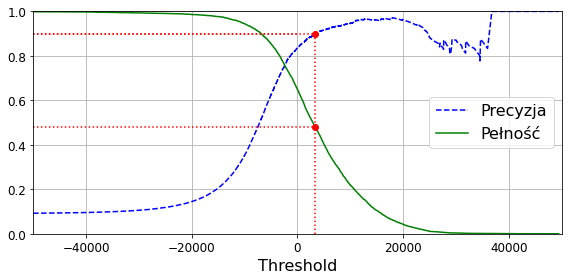

In [32]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # pełność dla precyzji przekraczającej 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # próg dla precyzji przekraczającej 90%

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") # x=threshold_90_precision, y = <0,0.9>, pionowa linia
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") #pozioma linia
plt.plot([-50000, recall_90_precision], [0.9, 0.9], "r:") #pozioma linia
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

In [51]:
(y_train_pred == (y_scores > 0)).all()

False

## Precision/Recall function (wykres PR)

Saving figure precision_vs_recall_plot


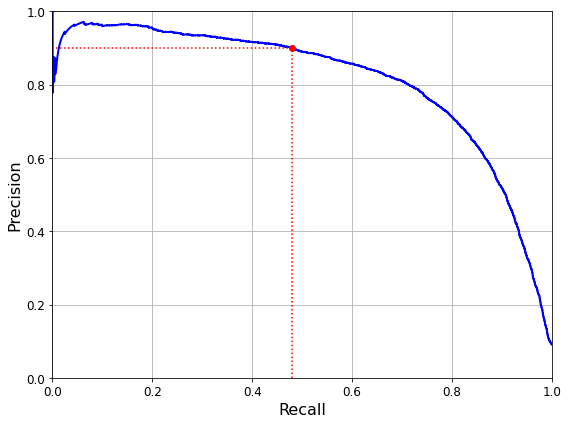

In [50]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [37]:
threshold_90_precision = thresholds[np.argmax(precisions >= .90)]
threshold_90_precision


3370.0194991439557

In [73]:
recall_90_precision

0.4799852425751706

In [40]:
y_train.shape


(60000,)

In [42]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [43]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## Krzywa ROC 
ROC - reciever opearating statistics (charakterystyka robocza odbiornika)

In [53]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


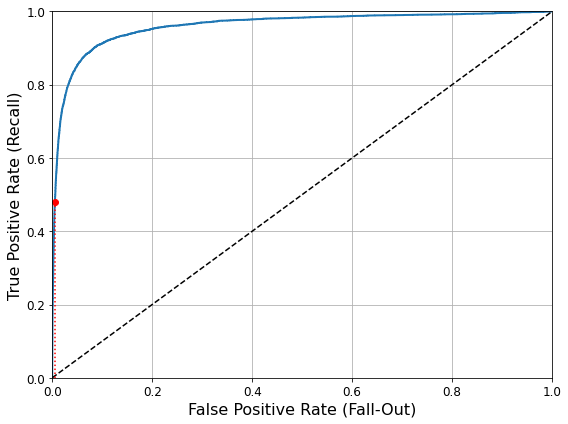

In [54]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)

# indeks % fałszywie pozytywnych w momencie gdy wartość prawdziwie pozytywnych przekracza wartość pełności dla 90% precyzji
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]             
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

### AUC (Area Under the Curve)
Służy do porównywania klasyfikatorów, przy klasyfikatorze doskonałym daje wartość 1 przy całkowicie losowym 0.5 i wykres wtedy zbliżony jest do krzywej diagonalnej

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [61]:
y_probas_forest # każda kolumna to prawdopodobieństwo przynależności do jakiejś klasy

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [63]:
y_scores_forest = y_probas_forest[:,1] # wycinanie wyników przynależności do klasy pozytywnej
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest) 

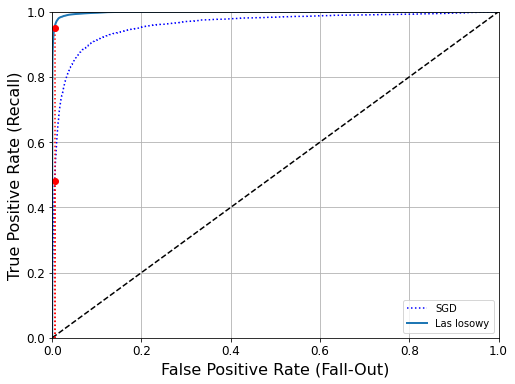

In [86]:
# indeks PP wartości dla których wartość fałszywie pozytywnych wartości lasu losowego przekracza wartość fałszywie pozytywnych wartości dla precyzji 90%
recall_for_forest = tpr_forest[np.argmax(fpr_forest > fpr_90)]

plt.figure(figsize=(8, 6)) 

plt.plot(fpr,tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Las losowy")

plt.plot([fpr_90,fpr_90], [0, recall_90_precision], "r:")
plt.plot(fpr_90, recall_90_precision, "ro")

plt.plot([fpr_90,fpr_90], [0, recall_for_forest], "r:")
plt.plot(fpr_90, recall_for_forest, "ro")

plt.legend(loc="lower right")
plt.show()

In [88]:
roc_auc_score(y_train_5, y_scores_forest) # pole pod powierzchnią wykresu znacznie korzystniejsze

0.9983436731328145

In [97]:
y_scores_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [98]:
precision_score(y_train_5, y_scores_forest_pred)

0.9905083315756169

In [99]:
recall_score(y_train_5, y_scores_forest_pred)

0.8662608374838591

# Klasyfikacja wieloklasowa

In [100]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

NameError: name 'psome_digit' is not defined

In [103]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [104]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [105]:
np.argmax(some_digit_scores)

5

In [106]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [107]:
svm_clf.classes_[5]

5

In [109]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [110]:
len(ovr_clf.estimators_)

10

In [112]:
ovr_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [114]:
from sklearn.linear_model import SGDClassifier

#długi czas działania
#sgd_clf.fit(X_train, y_train)
#sgd_clf.predict([some_digit])

KeyboardInterrupt: 

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [115]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Analiza błędów

In [116]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

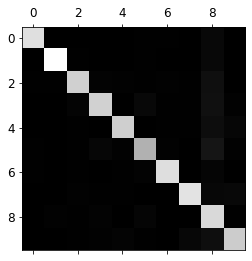

In [117]:
# RZĘDY - rzeczywiste klasy, KOLUMNY - klasy przewidziane
plt.matshow(conf_mx, cmap=plt.cm.gray) # graficzna reprezentacja macierzy pomyłek
plt.show()

In [118]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # sumowanie ilości wystąpień poszczególnych cyfr 
norm_conf_mx = conf_mx / row_sums # dzielenie błędów przez ilość wystąpień danej cyfry

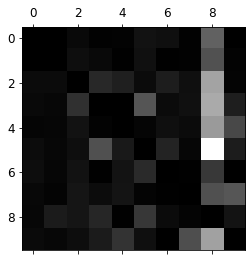

In [119]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [123]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

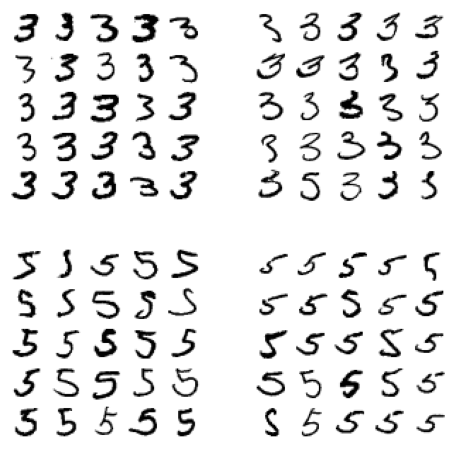

In [124]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Klasyfikator SGD przydziela wagi przynależności klasy do danego piksela i sumuje później poziomy szarości danych pikseli. Jest to dość prosty sposób klasyfikacji co może powodować różne błędy, aby je zminimalizować powinno się przetworzyć obrazy wejściowe tak by były one wyśrodkowane i odpowiednio obrócone. Nawet drobne zmiany wpływają na dokładność tego modelu.

# Klasyfikacja wieloetykietowa - multilabel classification
System zdolny do wyznaczania wielu binarnych znaczników. Przykład: jeśli nauczymy model 

In [128]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [129]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [130]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") # jeśli byłaby dysproporcja między ilością próbek danej klasy
# należałoby nadać większą wagę tym klasą których próbek jest więcej i wstawić wyrażenie average="weighted"

0.976410265560605

# Klasyfikacja wielowyjściowo-wieloklasowa
## multioutput-multiclass classification
Zwana również klasyfikacja wielowyjściową - multioutput classification

In [131]:
# Tworzenie zaszumionych próbek zawierających obrazki cyfr
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [133]:
some_index = 0

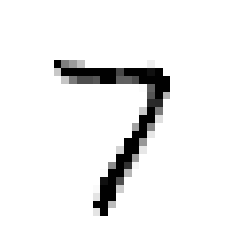

In [134]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Ćwiczenie 1

In [145]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights':["uniform", "distance"], 'n_neighbors': [4,5]}
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END n_neighbors=4, weights=uniform;, score=(train=0.980, test=0.966) total time=  22.7s
[CV 2/3] END n_neighbors=4, weights=uniform;, score=(train=0.980, test=0.966) total time=  24.7s
[CV 3/3] END n_neighbors=4, weights=uniform;, score=(train=0.981, test=0.967) total time=  25.2s
[CV 1/3] END n_neighbors=4, weights=distance;, score=(train=1.000, test=0.971) total time=  22.8s
[CV 2/3] END n_neighbors=4, weights=distance;, score=(train=1.000, test=0.970) total time=  24.4s
[CV 3/3] END n_neighbors=4, weights=distance;, score=(train=1.000, test=0.970) total time=  23.6s
[CV 1/3] END n_neighbors=5, weights=uniform;, score=(train=0.979, test=0.968) total time=  24.6s
[CV 2/3] END n_neighbors=5, weights=uniform;, score=(train=0.979, test=0.967) total time=  25.3s
[CV 3/3] END n_neighbors=5, weights=uniform;, score=(train=0.979, test=0.968) total time=  24.2s
[CV 1/3] END n_neighbors=5, weights=distance;, score=(train=1.00

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [4, 5],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [146]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [148]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [149]:
grid_search.cv_results_

{'mean_fit_time': array([0.17256149, 0.20114128, 0.19253182, 0.19580968]),
 'std_fit_time': array([0.00282787, 0.00447457, 0.00593444, 0.00734472]),
 'mean_score_time': array([24.10937246, 23.46433878, 24.63547095, 23.40955512]),
 'std_score_time': array([1.08794512, 0.65609285, 0.44845608, 0.42185766]),
 'param_n_neighbors': masked_array(data=[4, 4, 5, 5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 4, 'weights': 'uniform'},
  {'n_neighbors': 4, 'weights': 'distance'},
  {'n_neighbors': 5, 'weights': 'uniform'},
  {'n_neighbors': 5, 'weights': 'distance'}],
 'split0_test_score': array([0.96625, 0.9709 , 0.9676 , 0.9688 ]),
 'split1_test_score': array([0.9664 , 0.9698 , 0.9671 , 0.96795]),
 'split2_test_score': array([0.

In [ ]:
cvres = grid_search.cv_results_
for score, params in zip(cvres[])

In [150]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# Ćwiczenie 2

In [342]:
def extend_dataset(arr, labels):
    
    arr = arr.reshape(arr.shape[0],28,28)
    print(arr.shape)
    arr_left = np.roll(arr, -1, axis=2)
    arr_right = np.roll(arr, 1, axis=2)
    arr_top = np.roll(arr, -1, axis=1)
    arr_bottom = np.roll(arr, 1, axis=1)
    X_result = np.r_[arr_left,arr_right,arr_top,arr_bottom]
    y_labels = np.r_[labels,labels,labels,labels]
 
    return X_result.reshape(arr.shape[0]*4,-1), y_labels

In [343]:
X_train_extended, y_train_extended = extend_dataset(X_train, y_train)

(60000, 28, 28)


In [344]:
X_train.shape

(60000, 784)

In [345]:
X_train_extended.shape

(240000, 784)

In [346]:
y_train_extended.shape

(240000,)

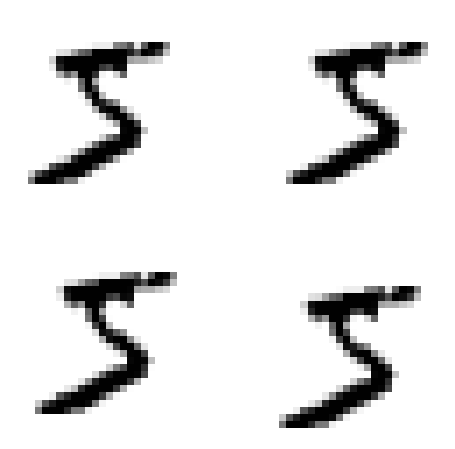

In [347]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digit(X_train_extended[0])
plt.subplot(222); plot_digit(X_train_extended[60000])
plt.subplot(223); plot_digit(X_train_extended[120000])
plt.subplot(224); plot_digit(X_train_extended[180000])
plt.show()

In [348]:
shuffle_idx = np.random.permutation(len(X_train_extended))
X_train_extended = X_train_extended[shuffle_idx]
y_train_extended = y_train_extended[shuffle_idx]

In [349]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_extended, y_train_extended)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [350]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9743